In [1]:
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
plt.rc("figure", figsize=(12,6))

In [2]:
X, y, coef = make_regression(n_samples=1000, n_features=10, coef=True)
coef

array([44.5914671 , 58.53700794, 46.94997106, 27.791022  , 65.66346474,
       24.74697264,  9.65318744, 14.89121931, 46.03838695, 55.67821556])

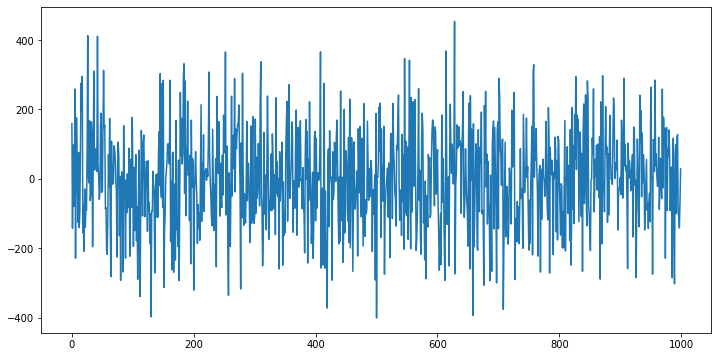

In [3]:
plt.plot(y);

## Vanilla Python

In [4]:
def py_dot_product(vec1, vec2):
    size = len(vec1)
    result = [0] * size
    for i in range(size):
        result[i] = vec1[i] * vec2[i]
    return sum(result)
    
def py_forward(w, X):
    size = len(X)
    y_pred = [0] * size
    for i in range(size):
        y_pred[i] = py_dot_product(X[i], w)
    return y_pred

def py_loss(y_pred, y):
    size = len(y)
    result = 0
    for i in range(size):
        sq = (y_pred[i] - y[i]) ** 2
        result += sq
    return result / (2*size)

def py_grad(y_pred, X, y):
    size = len(y)
    column_size = len(X[0])
    grad = [0] * column_size
    for i in range(size):
        vals = [0] * column_size
        for j in range(column_size):
            grad[j] += (y_pred[i] - y[i]) * X[i][j]
    return grad
            
def py_update_params(w, grad, lr):
    return [w[i] - lr * grad[i] for i in range(len(w))]

In [5]:
## Does not work
# X_temp = X.tolist()
# py_X = [[1] * 11] * 1000
# for i in range(len(py_X)):
#     py_X[i][1:] = X_temp[i]

In [6]:
py_X = np.insert(X, 0, 1, axis=1).tolist()
py_y = y.tolist()
py_w = [0]*len(py_X[0])

In [7]:
n_iter = 100
history = [0] * n_iter
for i in range(n_iter):
    pred = py_forward(py_w, py_X)

    history[i] = py_loss(pred, py_y)
    
    grad = py_grad(pred, py_X, py_y)

    py_w = py_update_params(py_w, grad, 0.0001)

In [8]:
np.array(py_w[1:])

array([44.5922098 , 58.53614292, 46.94808627, 27.79021003, 65.66211838,
       24.74679906,  9.65431203, 14.89172621, 46.03778439, 55.67552119])

In [9]:
coef

array([44.5914671 , 58.53700794, 46.94997106, 27.791022  , 65.66346474,
       24.74697264,  9.65318744, 14.89121931, 46.03838695, 55.67821556])

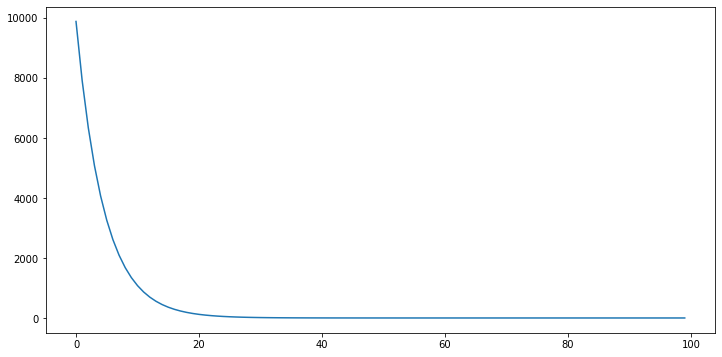

In [10]:
plt.plot(history);

## Numpy

In [11]:
def np_forward(w, X):
    return X.dot(w)

def np_loss(y_pred, y):
    return np.mean((y_pred - y)**2) / 2

def np_grad(y_pred, X, y):
    column_size = X.shape[1]
    grad = np.empty(column_size)
    for i in range(column_size):
        grad[i] = np.sum((y_pred - y) * X[:, i])
    return grad

# Pass by reference
def np_update_params(w, grad, lr):
    w -= lr * grad

In [12]:
np_X = np.insert(X, 0, 1, axis=1)
np_y = y
np_w = np.zeros(np_X.shape[1])

In [13]:
pred = np_forward(np_w, np_X)
np_grad(pred, np_X, np_y)

array([   524.59020259, -50052.60267528, -62243.66257495, -46254.87175789,
       -29711.15468259, -69020.93264325, -25258.20063471, -14294.01961054,
       -20441.42603685, -47051.21634087, -56134.98696859])

In [14]:
n_iter = 10
history = np.empty(n_iter)
for i in range(n_iter):
    pred = np_forward(np_w, np_X)
    
    history[i] = np_loss(pred, np_y)
    
    grad = np_grad(pred, np_X, np_y)
    
    np_update_params(np_w, grad, 0.001)

In [15]:
np_w[1:]

array([44.5914671 , 58.53700724, 46.94997092, 27.79102078, 65.66346468,
       24.74697255,  9.65318653, 14.89121759, 46.03838773, 55.67821531])

In [16]:
coef

array([44.5914671 , 58.53700794, 46.94997106, 27.791022  , 65.66346474,
       24.74697264,  9.65318744, 14.89121931, 46.03838695, 55.67821556])

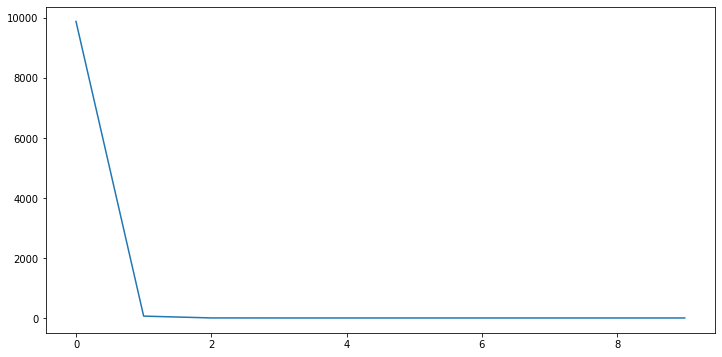

In [17]:
plt.plot(history);

## Jax

In [18]:
import jax
from jax import jit
from jax import grad as jgrad
from jax import numpy as jnp

# Setting device to cpu
jax.config.update('jax_platform_name', 'cpu')

In [19]:
@jit
def jax_forward(w, X):
    return X.dot(w)

@jit
def jax_loss(w, X, y):
    y_pred = jax_forward(w, X)
    return jnp.mean(jnp.square(y_pred - y)) / jnp.array(2.)

jax_grad = jit(jgrad(jax_loss))

@jit
def jax_update_params(w, grad, lr):
    # Jax does not allow side effects
    # So have to return a new array
    return w - grad * lr

In [20]:
# Jax have not implemented insertion yet
# and I do not think it will because of
# its functional and immutable arrays

jax_X = jnp.array(np.insert(X, 0, 1, axis=1))
jax_y = jnp.array(y)
jax_w = jnp.zeros(jax_X.shape[1])

In [21]:
n_iter = 10
history = jnp.empty(n_iter)
lr = jnp.array(1)
for i in range(n_iter):
    pred = jax_forward(jax_w, jax_X)
    
    loss = jax_loss(jax_w, jax_X, jax_y)
    history = jax.ops.index_update(history, i, loss)
    
    grad = jax_grad(jax_w, jax_X, jax_y)

    # For me gradients were 1000 times smaller than numpy
    # for this reason I choose learning rate = 1
    jax_w = jax_update_params(jax_w, grad, lr)

In [22]:
jax_w[1:]

DeviceArray([44.59147 , 58.537006, 46.94997 , 27.79102 , 65.66347 ,
             24.746971,  9.653187, 14.891217, 46.038387, 55.678215],            dtype=float32)

In [23]:
coef

array([44.5914671 , 58.53700794, 46.94997106, 27.791022  , 65.66346474,
       24.74697264,  9.65318744, 14.89121931, 46.03838695, 55.67821556])

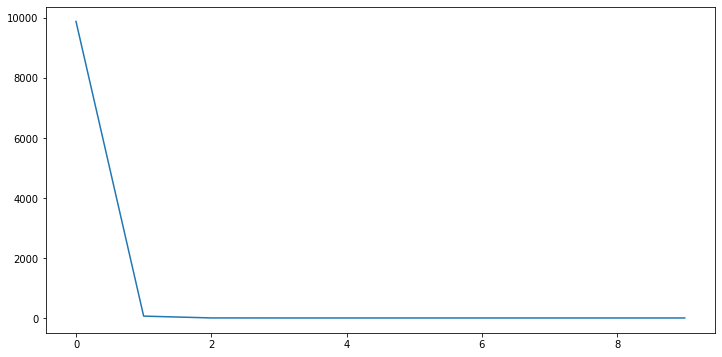

In [24]:
plt.plot(history);

## MxNet

In [52]:
import mxnet as mx

In [53]:
def mx_forward(w, X):
    return mx.nd.dot(mx_X, mx_w)

def mx_loss(y_pred, y):
    return mx.nd.mean(mx.nd.square(y_pred - y)) / 2.0

def mx_update_params(w, grad, lr):
    return w - lr * grad

In [54]:
# Mx already uses numpy inserting
# so I used numpy 
mx_X = mx.nd.array(np.insert(X, 0, 1, axis=1))
mx_y = mx.nd.array(y)
mx_w = mx.nd.zeros((mx_X.shape[1]))

In [55]:
n_iter = 10
history = mx.nd.empty(n_iter)
for i in range(n_iter):
    mx_w.attach_grad()
    with mx.autograd.record():
        pred = mx_forward(mx_w, mx_X)
        loss = mx_loss(pred, mx_y)
    history[i] = loss.asscalar()
    loss.backward()
    
    # Same as jax gradients were 1000 times smaller than numpy
    # for this reason I choose learning rate = 1
    mx_w = mx_update_params(mx_w, mx_w.grad, 1)

In [56]:
mx_w[1:].asnumpy()

array([44.59147 , 58.537006, 46.94997 , 27.791021, 65.66347 , 24.746971,
        9.653187, 14.891217, 46.038387, 55.678215], dtype=float32)

In [57]:
coef

array([44.5914671 , 58.53700794, 46.94997106, 27.791022  , 65.66346474,
       24.74697264,  9.65318744, 14.89121931, 46.03838695, 55.67821556])

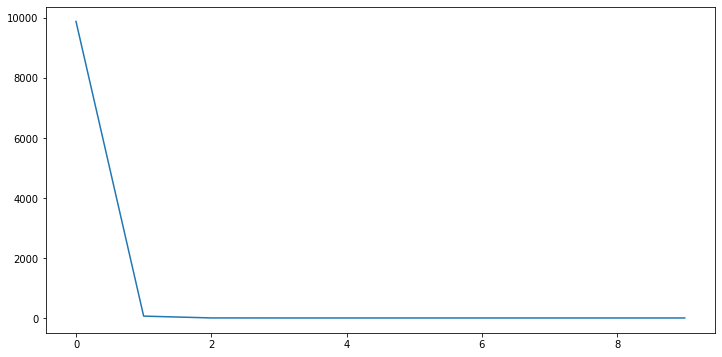

In [58]:
plt.plot(history.asnumpy());

## Tensorflow 

In [32]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
for device in visible_devices:
    assert device.device_type != 'GPU'

In [33]:
# Insertion can be done with scatter
# but due to immutability of tensor
# I prefer to use numpy again
tf_X = tf.constant(np.insert(X, 0, 1, axis=1))
tf_y = tf.constant(y)
tf_w = tf.Variable(tf.zeros((tf_X.shape[1]), dtype=tf.double))

In [34]:
def tf_forward(w, X):
    return tf.tensordot(tf_X, tf_w, 1)

def tf_loss(y_pred, y):
    return tf.math.reduce_mean(tf.math.squared_difference(y_pred, y)) / 2.

def tf_update_params(w, grad, lr):
    # Do not do operations without builtin assing op functions
    # Or it will break variable and tf cannot calculate gradients
    w.assign_sub(lr * grad)

In [35]:
n_iter = 10
# What I hate about tensorflow is that it is a real close box
# You cannot assign a value by all correctness
# There is always you a caveat, so I had to use numpy for history
history = np.empty(n_iter)
for i in range(n_iter):
    with tf.GradientTape() as tape:
        pred = tf_forward(tf_w, tf_X)
        loss = tf_loss(pred, tf_y)
    history[i] = loss.numpy()
    grad = tape.gradient(loss, tf_w)

    # Same as jax gradients were 1000 times smaller than numpy
    # for this reason I choose learning rate = 1
    tf_update_params(tf_w, grad, 1.0)

In [36]:
tf_w[1:].numpy()

array([44.5914671 , 58.53700724, 46.94997092, 27.79102078, 65.66346468,
       24.74697255,  9.65318653, 14.89121759, 46.03838773, 55.67821531])

In [37]:
coef

array([44.5914671 , 58.53700794, 46.94997106, 27.791022  , 65.66346474,
       24.74697264,  9.65318744, 14.89121931, 46.03838695, 55.67821556])

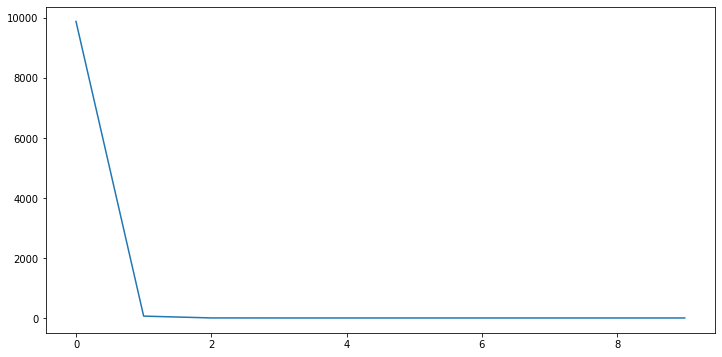

In [38]:
plt.plot(history);

## PyTorch

In [39]:
import torch

In [40]:
def torch_forward(w, X):
    return X @ w

def torch_loss(y_pred, y):
    return torch.mean(torch.square(y_pred - y)) / 2.

In [41]:
torch_X = torch.from_numpy(X)
torch_X = torch.cat((torch.ones((torch_X.shape[0], 1)), torch_X), 1)
torch_y = torch.from_numpy(y)
torch_w = torch.zeros(torch_X.shape[1], dtype=torch.float64, requires_grad=True)
optimizer = torch.optim.SGD([torch_w], lr=1)

In [42]:
n_iter = 10
history = torch.empty(n_iter)
for i in range(n_iter):
    pred = torch_forward(torch_w, torch_X)
    loss = torch_loss(pred, torch_y)
    history[i] = loss.item()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

In [43]:
torch_w[1:]

tensor([44.5915, 58.5370, 46.9500, 27.7910, 65.6635, 24.7470,  9.6532, 14.8912,
        46.0384, 55.6782], dtype=torch.float64, grad_fn=<SliceBackward>)

In [44]:
coef

array([44.5914671 , 58.53700794, 46.94997106, 27.791022  , 65.66346474,
       24.74697264,  9.65318744, 14.89121931, 46.03838695, 55.67821556])

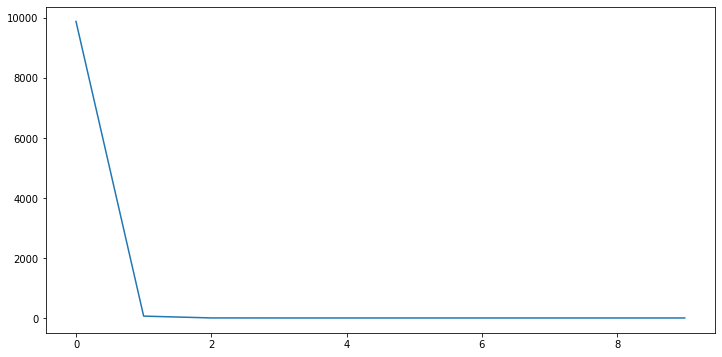

In [45]:
plt.plot(history);